# FINAL ML SUBSAMPLE RV CURVES SYNTHETIC DATASETS CREATION, WITH LIMITED PRECISION AND LONGER TIME BASELINE

In this notebook we create several synthetic samples of radial velocity (RV) curves, according to the statistical distribution of the relevant parameters, as inferred from the theory or from the real CARMENES RV curves in the ML subsample (233 stars). These synthetic samples will be used both for Machine Learning (ML) modelling purposes.

**NOTE:** there are only two differences in this notebook, compared to the previous _"SD_21_ML_Synth_samples_creation.ipynb"_ notebook. The first one is that the precision of the star paremeters is limited to a specific number of decimal positions, namely:

- $\Delta A=0.01\;\rm{ms}^{-1}$
- $\Delta \nu=0.01\;\rm{d}^{-1}$
- $\Delta \tau=0.0001\;\rm{d}$
- $\Delta \delta=0.01$
- $\Delta c=0.01\;\rm{ms}^{-1}$ (no effect for NZP-corrected RV curves, which always have offset equal to $0.00$).

The second diference is the longer time baseline generated for the first two synthetic signals (see below).

The basic equation to generate the signals is:

$$x(t)=A\cos\{2\pi(\nu(t-\tau)+\delta)\}+c$$

Notice that only single pulsations are modelled for each signal, i.e. only a single, fundamental tone is assumed for each signal.

The samples to be created are the following ones:

- Sample S1: the benchmark synthetic sample. This will be a noiseless, perfectly sampled dataset. This means having a good period frequency of $0.0016\;d$, above two times the Nyquist frequency for the minimum period to be detected, as well as a long enough time baseline so that the resolution of periodograms are coherent with the frequency precision used when creating the signal. The time baseline will be the same for all curves, so that the pulsations with shorter periods will include more complete periods in that time. The chosen time baseline of $100\;d$ is more than enough to cover many cycles ($\sim240$) of even the larger period searched for ($10\;h$).
- Sample S2: based on sample S1, we just apply to each data point a random noise, calculated from a pool of error margin distributions extracted from the real ML subsample of CARMENES RV curves.
- Sample S3: based on sample S1, we just apply to each curve a given sampling pattern, chosen randomly among the sampling patterns extracted from the real ML subsample of CARMENES RV curves.
- Sample S4: a combination of the distortions applied to generate S2 and S3. This sample will somehow mimic the real CARMENES RV curves in ML subsample, because it incorporates both the CARMENES error distributions and the typical sampling patterns of CARMENES RV curves. 

**IMPORTANT NOTE:** a fraction of $90\%$ of the stars will be randomly classified as non-pulsating stars, assigning them a constant valued time series. This value is based on the proper references (see the TFM document).

All the records for all the samples will be created in parallel, so that, for example, the sampling time values of a given record in sample S4 will be exactly the same values for the same record in sample S3, and both records (as well as that in sample S2) will share the same basic, clean oscillation parameters of the record in sample S1. The rationale behind this approach is that the corresponding records throughout all the samples conceivably represent the same physical object. Notice that noise values cannot be exactly shared between samples S2 and S4, as their time span and sampling patterns will be something completely different. However the statistical parameters to generate such noise values will be the same for corresponding records in samples S2 and S4.

A table with the description of each synthetic star and its corresponding record characteristics will be generated. The table will contain, for each star, all the basic parameters of the benchmark curve in sample S1 (amplitude, frequency, etc., basically modelling the pulsation in the physical object). Each record will have a sequential identifier for it, with the format "Star-\<j\>", being "j" a sequential value. For each record, files containing the generated RV curves will also be stored, with names like "S\<i\>-RV-Star-\<j\>.dat", being "i" the sample identifier (S1, S2, S3 and S4) and "j" the sequential star identifier. The names and relative paths to these files are also stored in the dataset table for later reference.

The time series files stored with _".dat"_ extension will have three columns separated by a space (corresponding to _time_, _value_ and _error_, without headers), so that we can load them straightaway into both _LSTperiod_ or use with `gls` Python module. Notice that for the noiseless samples (S1 and S3), the error value will be exactly $0\;ms^{-1}$, and that in calculations with `gls` we will have to select the option for classical LS periodogram, in order not to consider the _error_ column, which will produce a runtime error in the code execution. Later on we will adapt the format as required for feature extraction with the proper time series analysis package (_cesium_).

## Modules and configuration

### Modules

In [1]:
import math
import pandas as pd
import numpy as np

from IPython.display import clear_output

import json

from distfit import distfit

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
# CONFIGURATION:
MODE = "NEW" # 'NEW' to overwrite the existing datasets / 'APPEND' to add records to the datasets
N = 1000 # Number of records (i.e. RV curves) to create / add.
RANDOM_STATE = 11 # For reproducibility
np.random.seed(RANDOM_STATE) # For reproducibility

NON_PULSATION_FRACTION = 0.90 # Fraction of non-pulsating stars, a prior calculated from the proper references.

OVERRIDE_TOBS = 100.0 # Overriding value for time baseline.

IMAGE_FOLDER = "./img/"

DIST_SUMMARY_FILE = "../data/DIST_FILES/Parameter_distributions_ML_subsample_FINAL.csv"
#DIST_SUMMARY_FILE = "../data/DIST_FILES/Parameter_distributions_ML_subsample.csv"
DIST_FILES_FOLDER = "../data/DIST_FILES/"
RV_PATTERNS_FILE = "../data/DIST_FILES/RV_ML_subsample_sampling_patterns_and_noise_B_REPEAT.csv"

DATASETS_FOLDER = "../data/SYNTH_RV_SAMPLES/"
DATASETS_SUMMARY_FILE = "../data/SYNTH_RV_SAMPLES/RV_FINAL_ML_SyntheticDatasets.csv"
DS1_FOLDER = "../data/SYNTH_RV_SAMPLES/S1_FINAL_ts_files/"
DS2_FOLDER = "../data/SYNTH_RV_SAMPLES/S2_FINAL_ts_files/"
DS3_FOLDER = "../data/SYNTH_RV_SAMPLES/S3_FINAL_ts_files/"
DS4_FOLDER = "../data/SYNTH_RV_SAMPLES/S4_FINAL_ts_files/"

STAR_PREFIX="Star-" # RECOMMENDED - DO NOT CHANGE

NEGLIGIBLE_NOISE = 1e-6 # Used to set some noise column value for the "perfect" RV curve (S1 and S3 samples)

# ROUNDING DECIMALS:
AMPLITUDE_DECIMALS = 2
FREQUENCY_DECIMALS = 2
TAU_DECIMALS = 4
DELTA_DECIMALS = 2
OFFSET_DECIMALS = 2 # (NO EFFECT FOR NZP-CORRECTED RV CURVES WITH OFFSET = 0.00)

### Functions

In [3]:
def limit_value(x, low, high):
    x_limited = np.round(x, AMPLITUDE_DECIMALS)
    if x < low:
        x_limited = np.round(low, AMPLITUDE_DECIMALS)
    if x > high:
        x_limited = high
    return x_limited

In [4]:
def generate_errors(dist, min_value, max_value, size):
    '''Generate random values from a fitted distribution passed as parameter, but limiting
    them to the range between "min_value" and "max_value".'''
    error_values = np.round(error_dist.generate(n=size, verbose=0), AMPLITUDE_DECIMALS)
    limited_error_values = []
    limited_error_values = [limit_value(x=value,
                                        low=np.round(min_value, AMPLITUDE_DECIMALS),
                                        high=np.round(max_value, AMPLITUDE_DECIMALS)) for value in error_values]
    return limited_error_values

In [5]:
def real_value(t, f, A, c, tau, delta):
    '''Returns the value of a benchmark sample at a time 't', depending on the values of the parameters passed:
    f: frequency; A: amplitude; c: offset; tau: reference epoch; delta: phase; error: error margin'''
    # First generate the real value:
    real_value = np.round(A * np.cos(2 * np.pi * (f * (t - tau) + delta)) + c, AMPLITUDE_DECIMALS)
    return real_value

In [6]:
def observed_value(real_value, error):
    '''Generates a random observed value, given the real value and the error passed as parameters'''
    if error == 0:
        obs_value = np.round(real_value, AMPLITUDE_DECIMALS)
    else:
        norm_dist = norm(loc=real_value, scale=error) # The error indicated in RV curves corresponds 1-sigma
        obs_value = np.round(norm_dist.rvs(size=1), AMPLITUDE_DECIMALS)
    return obs_value  

In [7]:
np.pi

3.141592653589793

In [8]:
# We vectorize the previous functions to be able to pass arrays as parameters,
# in order to calculate the time series in one call
v_real_value = np.vectorize(real_value)
v_observed_value = np.vectorize(observed_value)

## Prepare distributions of parameters

### Read configuration file

Read the file containing the distributions and values used for dataset generation.

In [9]:
dist_params = pd.read_csv(DIST_SUMMARY_FILE, sep=',', decimal='.')
dist_params

,Group,Variable,Distribution,Dist_file
0,BENCHMARK,Ps,{'fixed_value': 0.0016},NaN
1,BENCHMARK,Tobs,{'fixed_value': 4.2},NaN
2,BENCHMARK,frequency,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_frequency_ML_subsample_dist.pickle
3,BENCHMARK,phase,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_phase_ML_subsample_dist.pickle
4,BENCHMARK,amplitudeRV,{'distr': <scipy.stats._continuous_distns.unif...,BENCHMARK_amplitudeRV_ML_subsample_dist.pickle
5,BENCHMARK,offsetRV,{'fixed_value': 0.0},NaN
6,BENCHMARK,refepochRV,{'distr': <scipy.stats._continuous_distns.logn...,BENCHMARK_refepochRV_ML_subsample_dist.pickle
7,RV,noiseRV,{'distr': <scipy.stats._continuous_distns.beta...,RV_noiseRV_ML_subsample_dist.pickle
8,RV,samplingperiodRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_samplingperiodRV_ML_subsample_dist.pickle
9,RV,numpointsRV,{'distr': <scipy.stats._continuous_distns.pare...,RV_numpointsRV_ML_subsample_dist.pickle


In [10]:
dist_params.dtypes

Group           object
Variable        object
Distribution    object
Dist_file       object
dtype: object

### Register the distributions to use for each variable

**Note:** take into account that we will not be using the distributions for `noiseRV`, `samplingperiodRV` and `numpointsRV`, as we will calculate these values in a diifferent way, i.e. not just drawing a value from a statistical distribution.

In [11]:
# Initialise variable:
param_ranges = {}
for i in range(0,len(dist_params)):
    try:
        # If successful, it is a fixed value:
        d = json.loads(dist_params.loc[i, 'Distribution'].replace('\'', '\"'))
        param_ranges[dist_params.loc[i, 'Variable']] = d
    except:
        # Must be a distribution, so we load it from file:
        try:
            d = distfit()
            d.load(DIST_FILES_FOLDER + dist_params.loc[i, 'Dist_file'])
            param_ranges[dist_params.loc[i, 'Variable']] = d
        except Exception as e:
            # Some error happened:
            print("***ERROR! Could not set parameter %s. Error: %s" \
                  %(dist_params.loc[i, 'Variable'], str(e)))


[pypickle] Pickle file loaded: [../data/DIST_FILES/BENCHMARK_frequency_ML_subsample_dist.pickle]
[pypickle] Pickle file loaded: [../data/DIST_FILES/BENCHMARK_phase_ML_subsample_dist.pickle]
[pypickle] Pickle file loaded: [../data/DIST_FILES/BENCHMARK_amplitudeRV_ML_subsample_dist.pickle]
[pypickle] Pickle file loaded: [../data/DIST_FILES/BENCHMARK_refepochRV_ML_subsample_dist.pickle]
[pypickle] Pickle file loaded: [../data/DIST_FILES/RV_noiseRV_ML_subsample_dist.pickle]
[pypickle] Pickle file loaded: [../data/DIST_FILES/RV_samplingperiodRV_ML_subsample_dist.pickle]
[pypickle] Pickle file loaded: [../data/DIST_FILES/RV_numpointsRV_ML_subsample_dist.pickle]


In [12]:
# Show result:
param_ranges

{'Ps': {'fixed_value': 0.0016},
 'Tobs': {'fixed_value': 4.2},
 'frequency': <distfit.distfit.distfit at 0x157cfa02940>,
 'phase': <distfit.distfit.distfit at 0x157ca3f2bb0>,
 'amplitudeRV': <distfit.distfit.distfit at 0x157cfa02d30>,
 'offsetRV': {'fixed_value': 0.0},
 'refepochRV': <distfit.distfit.distfit at 0x157cfa108b0>,
 'noiseRV': <distfit.distfit.distfit at 0x157cfa10790>,
 'samplingperiodRV': <distfit.distfit.distfit at 0x157cfa24f70>,
 'numpointsRV': <distfit.distfit.distfit at 0x157cfa33be0>}

## Create the random samples and the RV curve files

In [13]:
# TEST 1 - Vectorized function: clean time series.
test_real = v_real_value(t=[0.00, 0.50, 1.00, 1.50, 2.00, 2.50, 3.00, 3.50, 4.00, 4.50, 5.00, 5.50, 6.00, \
                            6.50, 7.00, 7.50, 8.00, 8.50, 9.00, 9.50, 10.00, 10.50, 11.00, 11.50],
                         f=0.75, A=5.0, c=20.0, tau=0.5, delta=0.2)
test_real

array([22.27, 21.55, 15.54, 24.76, 17.73, 18.45, 24.46, 15.24, 22.27,
       21.55, 15.54, 24.76, 17.73, 18.45, 24.46, 15.24, 22.27, 21.55,
       15.54, 24.76, 17.73, 18.45, 24.46, 15.24])

In [14]:
# TEST 2 - Vectorized function: noisy time series.
test_obs = v_observed_value(real_value=test_real,
                            error=[1.500668159, 1.379844309, 0.578035218, 0.798004417, 1.543720686, \
                                   1.188904223, 0.161336742, 0.102133465, 1.1281597, 0.933947801, \
                                   0.431082827, 0.865645144, 1.968325011, 0.070059952, 1.342700752, \
                                   0.102406912, 1.605073208, 0.089842491, 1.993361815, 0.190272377, \
                                   0.061971617, 1.836111736, 1.201716785, 0.221183952])
test_obs

array([21.84, 20.88, 14.01, 24.75, 17.24, 17.81, 24.51, 15.28, 21.07,
       20.72, 15.33, 25.36, 18.83, 18.36, 22.96, 15.32, 24.8 , 21.55,
       14.18, 24.97, 17.71, 19.78, 26.32, 15.38])

### Initialize samples table

In [15]:
if MODE == "NEW":
    # Initialise DataFrame:
    datasets = pd.DataFrame(columns=['ID', 'Pulsating', \
                                     'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', \
                                     'S1_Ps', 'S1_Tobs', \
                                     'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', \
                                     'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', \
                                     'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev', \
                                     'S3_sampling_idx', 'S3_Tobs', \
                                     'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', \
                                     'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev',
                                     'S1_file', 'S2_file', 'S3_file', 'S4_file'])
else:
    # 'APPEND' mode is assumed by default
    try:
        # Load existing DataFrame:
        datasets = pd.read_csv(DATASETS_SUMMARY_FILE, sep=',', decimal='.')
    except:
        print("**WARNING: no previous dataset table was found.\n" \
              "Switching to 'NEW' mode...")
        datasets = pd.DataFrame(columns=['ID', 'Pulsating', \
                                         'frequency', 'amplitudeRV', 'offsetRV', 'refepochRV', 'phase', \
                                         'S1_Ps', 'S1_Tobs', \
                                         'S2_errorRV_dist_idx', 'S2_errorRV_dist_name', \
                                         'S2_errorRV_dist_loc', 'S2_errorRV_dist_scale', \
                                         'S2_errorRV_mean', 'S2_errorRV_median', 'S2_errorRV_stdev', \
                                         'S3_sampling_idx', 'S3_Tobs', \
                                         'S3_Ps_mean', 'S3_Ps_median', 'S3_Ps_stdev', 'S3_NumPoints', \
                                         'S4_errorRV_mean', 'S4_errorRV_median', 'S4_errorRV_stdev',
                                         'S1_file', 'S2_file', 'S3_file', 'S4_file'])
        

In [16]:
datasets

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,S1_Tobs,S2_errorRV_dist_idx,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file


### Create the samples of time series in each dataset

In [17]:
# Read the sampling patterns from the RV patterns file:
rv_patterns = pd.read_csv(RV_PATTERNS_FILE)
rv_patterns['RV_sampling_deltas'] = rv_patterns['RV_sampling_deltas'] \
    .map(lambda x: json.loads(x))
rv_patterns.head()

,Karmn,Vr_kms-1,n_RV,Ps_RV,wrms_RV,RV_sampling_deltas,RV_noise_min,RV_noise_max,RV_noise_median,RV_noise_mean,RV_noise_stdev,RV_noise_dist,RV_noise_name,RV_noise_loc,RV_noise_scale,RV_noise_dist_file,RV_noise_fit_p-value,Fraction_Out,Occurrences
0,J23505-095,-21.870867,71.0,2.908164,3.362607,"[0.0, 11.957513123750687, 47.87879143701866, 5...",1.199479,4.170413,1.722917,1.881812,0.628702,{'distr': <scipy.stats._continuous_distns.t_ge...,t,1.691561,0.290193,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.103726,0.112676,25
1,J23492+024,-71.131000,373.0,1.143762,2.183867,"[0.0, 17.0164248123765, 190.38824744801968, 21...",0.951985,7.585994,1.517377,1.656111,0.599510,{'distr': <scipy.stats._continuous_distns.logn...,lognorm,0.862271,0.660178,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.490384,0.000000,32
2,J23431+365,-2.597000,23.0,17.057200,2.795865,"[0.0, 8.942367421463132, 9.875712749548256, 25...",0.916620,2.010952,1.377055,1.408319,0.262370,{'distr': <scipy.stats._continuous_distns.dwei...,dweibull,1.403768,0.233191,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.687567,0.043478,43
3,J23419+441,-77.764000,99.0,3.031857,2.532704,"[0.0, 136.37014811998233, 154.37618444254622, ...",0.829277,2.496016,1.297172,1.363447,0.307447,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.223698,0.212595,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.733246,0.000000,74
4,J23381-162,20.470749,56.0,3.019729,2.405056,"[0.0, 10.978803387377411, 30.955036497674882, ...",1.016080,3.446221,1.423674,1.611703,0.542434,{'distr': <scipy.stats._continuous_distns.gene...,genextreme,1.343269,0.248643,../data/DIST_FILES/RV_ML_subsample_Stars_noise...,0.482127,0.017857,74


In [18]:
param_ranges

{'Ps': {'fixed_value': 0.0016},
 'Tobs': {'fixed_value': 4.2},
 'frequency': <distfit.distfit.distfit at 0x157cfa02940>,
 'phase': <distfit.distfit.distfit at 0x157ca3f2bb0>,
 'amplitudeRV': <distfit.distfit.distfit at 0x157cfa02d30>,
 'offsetRV': {'fixed_value': 0.0},
 'refepochRV': <distfit.distfit.distfit at 0x157cfa108b0>,
 'noiseRV': <distfit.distfit.distfit at 0x157cfa10790>,
 'samplingperiodRV': <distfit.distfit.distfit at 0x157cfa24f70>,
 'numpointsRV': <distfit.distfit.distfit at 0x157cfa33be0>}

**IMPORTANT: SOME DISTRIBUTIONS OF ERROR VALUES SEEM TO YIELD NEGATIVE VALUES WHICH, WHEN PASSED ON TO A NORMAL DISTRIBUTION AS `SCALE`YIELDS ERROR, WE NEED TO DO TWO THINGS:**
- **ASSESS THE IMPACT OF THIS**: HOW MANY NEGATIVE VALUES HAPPEN? OR BETTER, ¿HOW MANY VALUES FALL OUTSIDE THE INITIAL RANGE OF VALUES?
- CORRECT THE ISSUE: WE HAVE TWO OPTIONS (NOT FULLY INCOMPATIBLE):
  - PREVENT NEGATIVE VALUES IN THE GENERATED ERROR MARGINS. NOT EASY... WHAT DO YOU DO WITH NEGATIVE VALUES?
  - ENTER ABSOLUTE MINIMUM AND MAXIMUM LIMITS FOR THE ERRORS. THESE ONES SHOULD BE CALCULATED AND RECORDED BEFOREHAND IN THE PREVIOUS NOTEBOOK "13", AND THEN USED IN THIS NOTEBOOK.

In [19]:
# Check t-deltas column name in the patterns file:
tdeltas_col = list(rv_patterns.columns).index("RV_sampling_deltas")
#for i in range(0, 1): # TEST
#for i in range(0, 5): # TEST
for i in range(len(datasets), len(datasets) + N):
    clear_output(wait=True)
    if True: # TEST
    #try:
        print("Processing record %d of %d..." %(i, N - 1))
        step = "Main parameters"
        # Set the record sequential ID and the pulsation characteristic:
        record_id = STAR_PREFIX + str(i).zfill(5)
        datasets.loc[i, 'ID'] = record_id
        #if np.asscalar(np.random.rand(1)) <= NON_PULSATION_FRACTION: # np.asscalar DEPRECATED
        if np.random.rand(1).item() <= NON_PULSATION_FRACTION:
            # Non-pulsating star:
            datasets.loc[i, 'Pulsating'] = False
            # Choose the main parameter values:
            # (one value per record, shared by all 4 distributions)
            # In this case, only the distributions for the offsetRV (which is 0.0 anyway) and refepochRV are used:
            frequency = np.round(0.0, FREQUENCY_DECIMALS)
            amplitudeRV = np.round(0.0, AMPLITUDE_DECIMALS)
            #offsetRV = np.round(param_ranges['offsetRV'].generate(n=1, verbose=0), OFFSET_DECIMALS)
            offsetRV = np.round(0.0, OFFSET_DECIMALS) # NZP-corrected RV time series
            refepochRV = np.round(param_ranges['refepochRV'].generate(n=1, verbose=0), TAU_DECIMALS)
            phase = np.round(0.0, DELTA_DECIMALS)
            # Populate the dataset table with the basic parameters:
            datasets.loc[i, 'frequency'] = frequency
            datasets.loc[i, 'amplitudeRV'] = amplitudeRV
            #datasets.loc[i, 'offsetRV'] = np.asscalar(offsetRV) # np.asscalar DEPRECATED
            #datasets.loc[i, 'offsetRV'] = offsetRV.item()
            datasets.loc[i, 'offsetRV'] = offsetRV
            #datasets.loc[i, 'refepochRV'] = np.asscalar(refepochRV) # np.asscalar DEPRECATED
            datasets.loc[i, 'refepochRV'] = refepochRV.item()
            datasets.loc[i, 'phase'] = phase
        else:
            # Pulsating star:
            datasets.loc[i, 'Pulsating'] = True
            # Choose the main parameter values:
            # (one value per record, shared by all 4 distributions)
            # All the distributions are used to calculate random parameters:
            frequency = np.round(param_ranges['frequency'].generate(n=1, verbose=0), FREQUENCY_DECIMALS)
            amplitudeRV = np.round(param_ranges['amplitudeRV'].generate(n=1, verbose=0), AMPLITUDE_DECIMALS)
            #offsetRV = np.round(param_ranges['offsetRV'].generate(n=1, verbose=0), OFFSET_DECIMALS)
            offsetRV = np.round(0.0, OFFSET_DECIMALS) # NZP-corrected RV time series
            refepochRV = np.round(param_ranges['refepochRV'].generate(n=1, verbose=0), TAU_DECIMALS)
            phase = np.round(param_ranges['phase'].generate(n=1, verbose=0), DELTA_DECIMALS)
            # Populate the dataset table with the basic parameters:
            #datasets.loc[i, 'frequency'] = np.asscalar(frequency) # np.asscalar DEPRECATED
            datasets.loc[i, 'frequency'] = frequency.item()
            
            #datasets.loc[i, 'amplitudeRV'] = np.asscalar(amplitudeRV) # np.asscalar DEPRECATED
            datasets.loc[i, 'amplitudeRV'] = amplitudeRV.item()

            #datasets.loc[i, 'offsetRV'] = np.asscalar(offsetRV) # np.asscalar DEPRECATED
            #datasets.loc[i, 'offsetRV'] = offsetRV.item()
            datasets.loc[i, 'offsetRV'] = offsetRV
            
            #datasets.loc[i, 'refepochRV'] = np.asscalar(refepochRV) # np.asscalar DEPRECATED
            datasets.loc[i, 'refepochRV'] = refepochRV.item()
            
            #datasets.loc[i, 'phase'] = np.asscalar(phase) # np.asscalar DEPRECATED
            datasets.loc[i, 'phase'] = phase.item()
        
        # S1: Generate the benchmark (noiseless, perfectly sampled) time series:
        step = "S1 calculation"        
        # Get the timestamps parameters (sampling period and observation time):
        Ps = param_ranges['Ps']['fixed_value']
        #Tobs = param_ranges['Tobs']['fixed_value']
        
        Tobs = OVERRIDE_TOBS # OVERRIDE VALUE FOR Tobs

        # Generate the timestamps (absolute values) and noise:
        ds1_time = np.linspace(refepochRV, refepochRV + Tobs, int(Tobs/Ps) + 1, endpoint=True)
        ds1_error = np.repeat(NEGLIGIBLE_NOISE, len(ds1_time)).reshape(-1,1)
        # Generate the values:
        ds1_value = v_real_value(t=ds1_time,
                                 f=frequency, A=amplitudeRV, c=offsetRV, tau=refepochRV, delta=phase)
        ds1_ts = np.stack([ds1_time, ds1_value, ds1_error], axis=1).reshape(-1,3)
        # Create the S1 filename:
        ds1_file = DS1_FOLDER + "S1-RV_LP_T100d_" + record_id + ".dat"
        # Store the S1 file:
        np.savetxt(ds1_file, ds1_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for S1:
        datasets.loc[i, 'S1_Ps'] = Ps
        datasets.loc[i, 'S1_Tobs'] = Tobs
        datasets.loc[i, 'S1_file'] = ds1_file
        
        # S2: Generate the noise and create the noisy time series:
        step = "S2 calculation"        
        # Choose a random error distribution from the pool:
        # Notice that this chosen error distribution will be reused to create S4.
        
        #errordist_idx = np.asscalar(np.random.randint(low=0, high=len(rv_patterns), size=1)) # np.asscalar DEPRECATED
        errordist_idx = np.random.randint(low=0, high=len(rv_patterns), size=1).item()
        
        error_dist = distfit()
        error_dist.load(rv_patterns.loc[errordist_idx, 'RV_noise_dist_file'])
        error_min = rv_patterns.loc[errordist_idx, 'RV_noise_min']
        error_max = rv_patterns.loc[errordist_idx, 'RV_noise_max']
        # Generate an error array equal in length to  S1:
        #ds2_error = error_dist.generate(n=len(ds1_time), verbose=0)
        ds2_error = generate_errors(dist=error_dist,
                                    min_value=error_min, max_value=error_max,
                                    size=len(ds1_time))
        ds2_error = np.array(ds2_error).reshape(-1,1)
        # Generate S2 time series (it is the S1 time series affected by random noise):
        ds2_value = v_observed_value(ds1_value, ds2_error)
        # Notice that the time axis is exactly the same as S1 sample.
        ds2_ts = np.stack([ds1_time, ds2_value, ds2_error], axis=1).reshape(-1,3)
        # Calculate error stats:
        
        # ds2_error_mean = np.asscalar(np.nanmean(ds2_error.flatten())) # np.asscalar DEPRECATED
        ds2_error_mean = np.nanmean(ds2_error.flatten())

        # ds2_error_median = np.asscalar(np.nanmedian(ds2_error.flatten())) # np.asscalar DEPRECATED
        ds2_error_median = np.nanmedian(ds2_error.flatten())

        # ds2_error_std = np.asscalar(np.nanstd(ds2_error.flatten())) # np.asscalar DEPRECATED
        ds2_error_std = np.nanstd(ds2_error.flatten())

        # Create the S2 filename:
        ds2_file = DS2_FOLDER + "S2-RV_LP_T100d_" + record_id + ".dat"
        # Store the S2 file:
        np.savetxt(ds2_file, ds2_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS2:
        datasets.loc[i, 'S2_errorRV_dist_idx'] = errordist_idx
        datasets.loc[i, 'S2_errorRV_dist_name'] = error_dist.model['name']
        try:
            datasets.loc[i, 'S2_errorRV_dist_loc'] = error_dist.model['loc']
        except:
            datasets.loc[i, 'S2_errorRV_dist_loc'] = np.nan
        try:
            datasets.loc[i, 'S2_errorRV_dist_scale'] = error_dist.model['scale']
        except:
            datasets.loc[i, 'S2_errorRV_dist_scale'] = np.nan
        datasets.loc[i, 'S2_errorRV_mean'] = ds2_error_mean
        datasets.loc[i, 'S2_errorRV_median'] = ds2_error_median
        datasets.loc[i, 'S2_errorRV_stdev'] = ds2_error_std
        datasets.loc[i, 'S2_file'] = ds2_file
        
        # S3: Generate the imperfectly sampled time series:
        step = "S3 calculation"        
        # Choose a random sampling pattern from the pool and generate the timestamps:
        # Notice that the chosen sampling pattern is independent from the chosen error distribution (i.e. not
        # the same index).
        #pattern_idx = np.asscalar(np.random.randint(low=0, high=len(rv_patterns), size=1))
        pattern_idx = np.random.randint(low=0, high=len(rv_patterns), size=1).item()

        rv_t_deltas = rv_patterns.iloc[pattern_idx, tdeltas_col]
        # Generate DS3 time series:
        ds3_time = refepochRV + rv_t_deltas
        ds3_error = np.repeat(NEGLIGIBLE_NOISE, len(ds3_time)).reshape(-1,)
        ds3_value = v_real_value(t=ds3_time,
                                 f=frequency, A=amplitudeRV, c=offsetRV, tau=refepochRV, delta=phase)
        ds3_ts = np.stack([ds3_time, ds3_value, ds3_error], axis=1).reshape(-1,3)
        # Calculate sampling stats:
        ds3_Tobs = ds3_time.max() - ds3_time.min()
        ds3_deltas = ds3_time[1:] - ds3_time[:-1]

        # ds3_PsRV_mean = np.asscalar(np.nanmean(ds3_deltas)) # np.asscalar DEPRECATED
        ds3_PsRV_mean = np.nanmean(ds3_deltas)

        # ds3_PsRV_median = np.asscalar(np.nanmedian(ds3_deltas)) # np.asscalar DEPRECATED
        ds3_PsRV_median = np.nanmedian(ds3_deltas)

        # ds3_PsRV_stdev = np.asscalar(np.std(ds3_deltas)) # np.asscalar DEPRECATED
        ds3_PsRV_stdev = np.nanstd(ds3_deltas)

        ds3_NumRV = len(ds3_time)
        # Create the S3 filename:
        ds3_file = DS3_FOLDER + "S3-RV_LP_" + record_id + ".dat"
        # Store the S3 file:
        np.savetxt(ds3_file, ds3_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS3:
        datasets.loc[i, 'S3_sampling_idx'] = pattern_idx
        datasets.loc[i, 'S3_Tobs'] = ds3_Tobs
        datasets.loc[i, 'S3_Ps_mean'] = ds3_PsRV_mean
        datasets.loc[i, 'S3_Ps_median'] = ds3_PsRV_median
        datasets.loc[i, 'S3_Ps_stdev'] = ds3_PsRV_stdev
        datasets.loc[i, 'S3_NumPoints'] = ds3_NumRV
        datasets.loc[i, 'S3_file'] = ds3_file

        # S4: Generate the noisy and imperfectly sampled time series:
        step = "S4 calculation"        
        # Generate an error array equal in length to  S1:
        # Notice that we reuse the erro distribution chosen for sample S2.
        #ds4_error = error_dist.generate(n=len(ds3_time), verbose=0)
        ds4_error = generate_errors(dist=error_dist,
                                    min_value=error_min, max_value=error_max,
                                    size=len(ds3_time))
        ds4_error = np.array(ds4_error).reshape(-1,)
        # Generate S4 time series (it is the S3 time series affected by random noise):
        ds4_value = v_observed_value(ds3_value, ds4_error)
        # Notice that the time axis is exactly the same as S1 sample.
        ds4_ts = np.stack([ds3_time, ds4_value, ds4_error], axis=1).reshape(-1,3)
        # Calculate noise stats:
        # ds4_error_mean = np.asscalar(np.nanmean(ds4_error.flatten())) # np.asscalar DEPRECATED
        ds4_error_mean = np.nanmean(ds4_error.flatten())

        # ds4_error_median = np.asscalar(np.nanmedian(ds4_error.flatten())) # np.asscalar DEPRECATED
        ds4_error_median = np.nanmedian(ds4_error.flatten())

        # ds4_error_std = np.asscalar(np.nanstd(ds4_error.flatten())) # np.asscalar DEPRECATED
        ds4_error_std = np.nanstd(ds4_error.flatten())

        # Create the S4 filename:
        ds4_file = DS4_FOLDER + "S4-RV_LP_" + record_id + ".dat"
        # Store the S4 file:
        np.savetxt(ds4_file, ds4_ts, delimiter=' ')
        # Populate the dataset table with the relevant data for DS4:
        datasets.loc[i, 'S4_errorRV_mean'] = ds4_error_mean
        datasets.loc[i, 'S4_errorRV_median'] = ds4_error_median
        datasets.loc[i, 'S4_errorRV_stdev'] = ds4_error_std
        datasets.loc[i, 'S4_file'] = ds4_file
    
        # Store the dataset table so far:
        datasets.to_csv(DATASETS_SUMMARY_FILE, sep=',', decimal='.', index=False)
    
    else: # TEST
    #except Exception as e:
        # Report any possible trouble:
        print("***ERROR: some error happened when generating record %d, at step '%s' Error: %s" \
              %(i, step, str(e)))

print("--- FINISHED ---")

Processing record 999 of 999...
[pypickle] Pickle file loaded: [../data/DIST_FILES/RV_ML_subsample_Stars_noise_dist/J03531+625_RV_noise.pickle]
--- FINISHED ---


In [20]:
datasets

,ID,Pulsating,frequency,amplitudeRV,offsetRV,refepochRV,phase,S1_Ps,S1_Tobs,S2_errorRV_dist_idx,...,S3_Ps_median,S3_Ps_stdev,S3_NumPoints,S4_errorRV_mean,S4_errorRV_median,S4_errorRV_stdev,S1_file,S2_file,S3_file,S4_file
0,Star-00000,True,51.08,1.67,0.0,2457481.7903,0.93,0.0016,100.0,209,...,12.48699,423.473643,11,1.494545,1.43,0.300768,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
1,Star-00001,True,57.69,12.93,0.0,2457409.5058,0.13,0.0016,100.0,78,...,3.807657,30.022301,62,1.514677,1.415,0.347826,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
2,Star-00002,True,56.6,8.21,0.0,2457394.8499,0.33,0.0016,100.0,218,...,10.074961,40.909038,66,1.377424,1.265,0.35709,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
3,Star-00003,False,0.0,0.0,0.0,2457395.311,0.0,0.0016,100.0,28,...,15.987473,56.735394,52,1.907308,1.655,0.680636,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
4,Star-00004,True,22.21,8.11,0.0,2457500.1353,0.1,0.0016,100.0,6,...,26.947282,162.151502,24,1.23875,1.095,0.328967,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Star-00995,False,0.0,0.0,0.0,2457441.0411,0.0,0.0016,100.0,25,...,25.953213,90.32701,10,2.41,2.0,1.184922,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
996,Star-00996,False,0.0,0.0,0.0,2457405.9976,0.0,0.0016,100.0,203,...,7.031455,139.291882,6,1.555,1.285,0.689124,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
997,Star-00997,False,0.0,0.0,0.0,2457706.8805,0.0,0.0016,100.0,50,...,2.002482,16.384223,364,1.719863,1.59,0.52057,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...
998,Star-00998,True,33.16,16.26,0.0,2457397.9786,0.28,0.0016,100.0,197,...,9.023501,50.228453,78,7.452564,6.315,2.241105,../data/SYNTH_RV_SAMPLES/S1_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S2_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S3_C01D_50P_ts_files/...,../data/SYNTH_RV_SAMPLES/S4_C01D_50P_ts_files/...


### Show the last curves generated

#### Basic parameters of the curve

In [21]:
# Basic parameters:
print("PARAMETERS OF THE CURVE:")
if datasets.loc[i, 'Pulsating'] == True:
    print("Star type: Pulsating star")
    print("Amplitude: %f" %amplitudeRV[0])
    print("Frequency: %f" %frequency[0])
    print("Reference epoch: %f" %refepochRV[0])
    print("Phase: %f" %phase[0])
    print("Offset: %f" %offsetRV)
    print("Benchmark (perfect) sampling period: %f" %Ps)
    print("Benchmark (perfect) observation time: %f" %Tobs)
else:
    print("Star type: Non-pulsating star")
    print("Amplitude: %f" %amplitudeRV)
    print("Frequency: %f" %frequency)
    print("Reference epoch: %f" %refepochRV[0])
    print("Phase: %f" %phase)
    print("Offset: %f" %offsetRV)
    print("Benchmark (perfect) sampling period: %f" %Ps)
    print("Benchmark (perfect) observation time: %f" %Tobs)    

PARAMETERS OF THE CURVE:
Star type: Pulsating star
Amplitude: 14.920000
Frequency: 41.100000
Reference epoch: 2457782.389700
Phase: 0.120000
Offset: 0.000000
Benchmark (perfect) sampling period: 0.001600
Benchmark (perfect) observation time: 100.000000


#### Simplified, quick plots

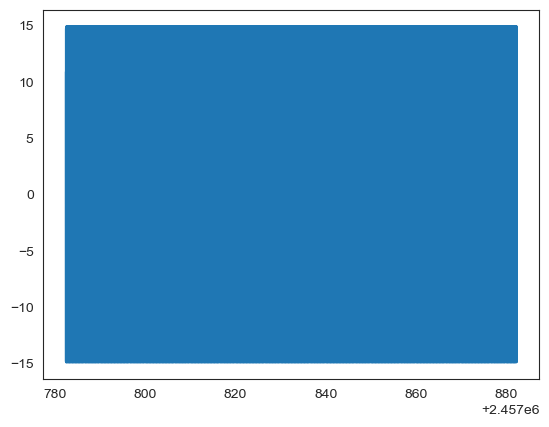

In [22]:
# S1 benchmark curve:
plt.plot(ds1_time, ds1_value)

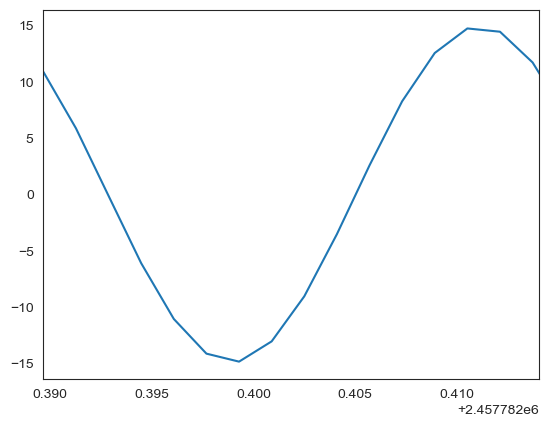

In [23]:
# S1 benchmark curve - Only 1 period:
try:
    # Pulsating star:
    plt.plot(ds1_time, ds1_value)
    plt.xlim(ds1_time.min(), ds1_time.min()+1/frequency[0])
except:
    # Non pulsating star:
    plt.plot(ds1_time, ds1_value)
    #plt.xlim(ds1_time.min(), ds1_time.min()+1/frequency)    

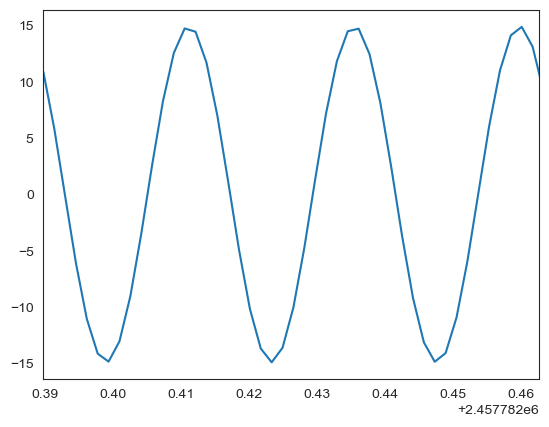

In [24]:
# S1 benchmark curve - Only 3 periods:
try:
    # Pulsating star:
    plt.plot(ds1_time, ds1_value)
    plt.xlim(ds1_time.min(), ds1_time.min()+3.0/frequency[0])
except:
    # Non pulsating star:
    plt.plot(ds1_time, ds1_value)
    #plt.xlim(ds1_time.min(), ds1_time.min()+1/frequency)    

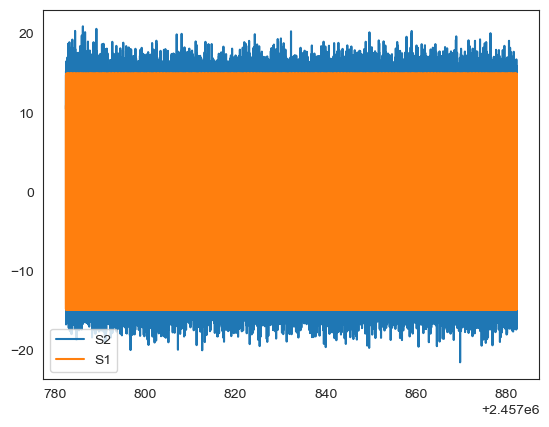

In [25]:
# S1 and S2 curves:
plt.plot(ds1_time, ds2_value, label='S2')
plt.plot(ds1_time, ds1_value, label='S1')
plt.legend()
plt.show();

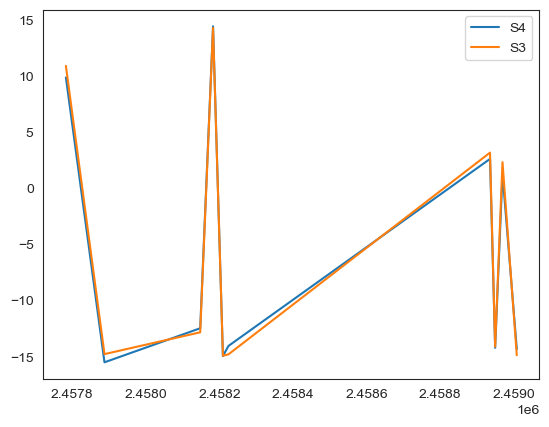

In [26]:
# DS3 and DS4 curves:
plt.plot(ds3_time, ds4_value, label='S4')
plt.plot(ds3_time, ds3_value, label='S3')
plt.legend()
plt.show();

#### More elaborated plots

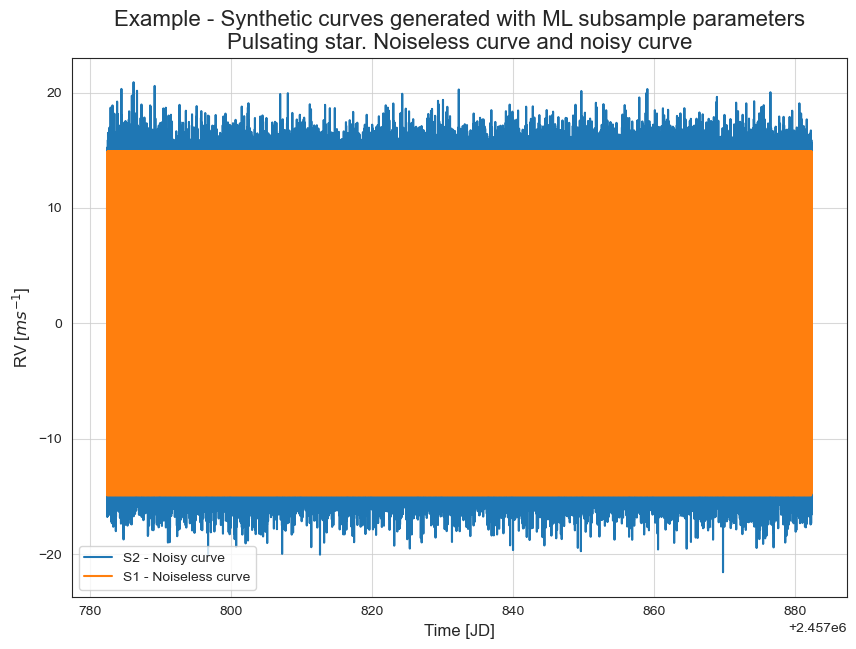

In [27]:
# S1 and S2 curves:
plt.figure(figsize=(10,7))
plt.title("Example - Synthetic curves generated with ML subsample parameters\n" \
          "Pulsating star. Noiseless curve and noisy curve", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Time [JD]", fontsize=12)
plt.ylabel('RV [$ms^{-1}$]', fontsize=12)
sns.lineplot(x=ds1_time.flatten(), y=ds2_value.flatten(), label='S2 - Noisy curve')
sns.lineplot(x=ds1_time.flatten(), y=ds1_value.flatten(), label='S1 - Noiseless curve')
plt.savefig(IMAGE_FOLDER + "SyntheticDataset_28_01_Example_Synthetic_curves_MS_subsample_S1_S2.jpg", format='jpg')
plt.show();

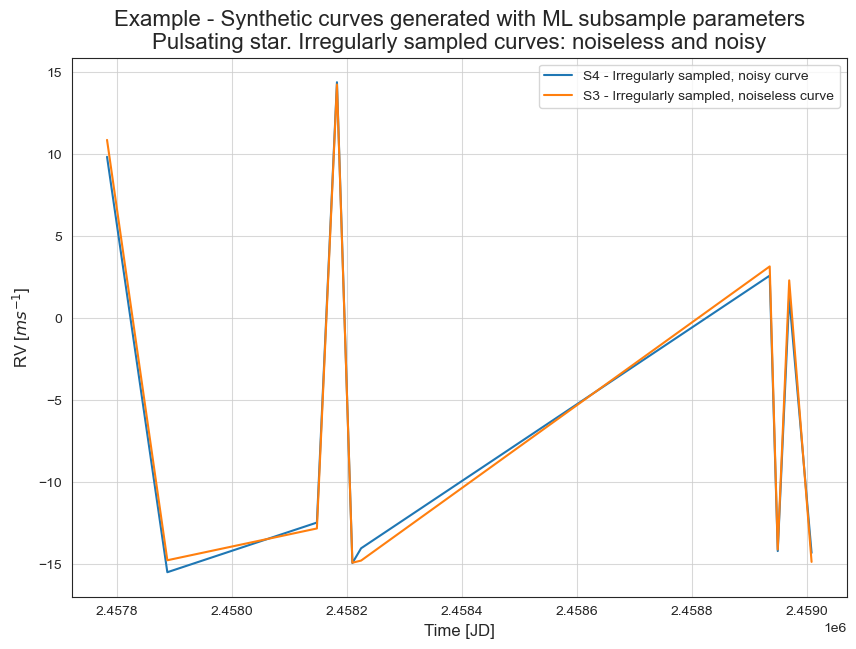

In [28]:
# S3 and S4 curves:
plt.figure(figsize=(10,7))
plt.title("Example - Synthetic curves generated with ML subsample parameters\n" \
          "Pulsating star. Irregularly sampled curves: noiseless and noisy", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Time [JD]", fontsize=12)
plt.ylabel('RV [$ms^{-1}$]', fontsize=12)
sns.lineplot(x=ds3_time.flatten(), y=ds4_value.flatten(), label='S4 - Irregularly sampled, noisy curve')
sns.lineplot(x=ds3_time.flatten(), y=ds3_value.flatten(), label='S3 - Irregularly sampled, noiseless curve')
plt.savefig(IMAGE_FOLDER + "SyntheticDataset_28_02_Example_Synthetic_curves_ML_subsample_S3_S4.jpg", format='jpg')
plt.show();